# 1.1 Classification of sectors with gradient descent algorithm


## Definition of the sectors

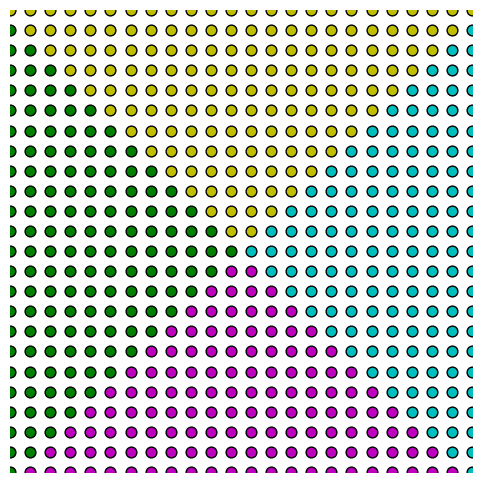

In [214]:
import numpy as np
import matplotlib.pyplot as plt

# Parameter
N = 24

# Coordinates
V = np.linspace(-2, 2, N) #Return evenly spaced 24 numbers over interval <-2,2>.
X, Y = np.meshgrid(V, V)  #Return a tuple of coordinate matrices from coordinate vectors.
Coordinates = np.vstack((X.ravel(), Y.ravel()))  #ravel - return a contiguous flattened array, vstack stacks arrays vertically

# Regions
Regions = 1 * (Y >= X) + 2 * ((Y > -X) | (np.abs(X + Y) < 1e-2)) + 1  #assigns 1,2,3,4 to regions based on Y,X values
Regions = Regions.ravel()

# Figure
plt.figure(figsize=(6, 6))
plt.axis('off')
plt.xlim([-2, 2])
plt.ylim([-2, 2])
Colors = ['m', 'g', 'c', 'y']

# Plot
for r in range(1, 5):
    I = np.where(Regions == r)
    plt.scatter(Coordinates[0, I], Coordinates[1, I], c=Colors[r-1], edgecolor='k', s=60)

plt.gca().set_aspect('equal', adjustable='box')
plt.show()


## TRaining Gradient Descent

In [215]:
import torch
import torch.nn as nn
import torch.optim as optim

Coordinates = torch.tensor(Coordinates.T, dtype=torch.float32)  #making tensor from coordinates array
Regions = torch.tensor(Regions, dtype=torch.long)

# Probabilities (one-hot encoding for 4 classes)
Probabilities = torch.zeros(4, len(Regions), dtype=torch.float32)  #create tensor filled with 0;s with size of 4 x len(reigons)
for n in range(len(Regions)):
    Probabilities[Regions[n]-1, n] = 1  

# MLP
class MultiLayerPerceptron(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(MultiLayerPerceptron, self).__init__()
        # Define layers
        self.l1 = nn.Linear(input_size, hidden_sizes[0])
        self.l2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.out = nn.Linear(hidden_sizes[1], output_size)
        self.act = nn.Softmax(dim=1)

    def forward(self, x):
        # Forward pass through the network
        x = self.l1(x)
        x = self.l2(x)
        x = self.out(x)
        return self.act(x)

# Initialize 
mlp = MultiLayerPerceptron(input_size=2, hidden_sizes=[4, 4], output_size=4)


# Loss function and optimizer
optimizer = optim.SGD(mlp.parameters(), lr=0.01, momentum=0.9)
criterion = nn.MSELoss()


# Options
epochs = 50
min_mse = 1e-8
batch_size = 10
num_batches = len(Coordinates) // batch_size

# Training 
for epoch in range(epochs):
    for i in range(num_batches):
        # Batch sampling
        start = i * batch_size
        end = start + batch_size
        inputs = Coordinates[start:end]
        targets = Probabilities[:, start:end].T 

        # Forward pass
        outputs = mlp(inputs)
        loss = criterion(outputs, targets)

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Print progress
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')
    if loss.item() <= min_mse:
        break

print("Training complete")


Epoch [1/50], Loss: 0.1023
Epoch [2/50], Loss: 0.0799
Epoch [3/50], Loss: 0.0665
Epoch [4/50], Loss: 0.0597
Epoch [5/50], Loss: 0.0538
Epoch [6/50], Loss: 0.0423
Epoch [7/50], Loss: 0.0231
Epoch [8/50], Loss: 0.0073
Epoch [9/50], Loss: 0.0020
Epoch [10/50], Loss: 0.0007
Epoch [11/50], Loss: 0.0003
Epoch [12/50], Loss: 0.0001
Epoch [13/50], Loss: 0.0001
Epoch [14/50], Loss: 0.0000
Epoch [15/50], Loss: 0.0000
Epoch [16/50], Loss: 0.0000
Epoch [17/50], Loss: 0.0000
Epoch [18/50], Loss: 0.0000
Epoch [19/50], Loss: 0.0000
Epoch [20/50], Loss: 0.0000
Epoch [21/50], Loss: 0.0000
Epoch [22/50], Loss: 0.0000
Epoch [23/50], Loss: 0.0000
Epoch [24/50], Loss: 0.0000
Epoch [25/50], Loss: 0.0000
Epoch [26/50], Loss: 0.0000
Epoch [27/50], Loss: 0.0000
Epoch [28/50], Loss: 0.0000
Epoch [29/50], Loss: 0.0000
Epoch [30/50], Loss: 0.0000
Epoch [31/50], Loss: 0.0000
Training complete


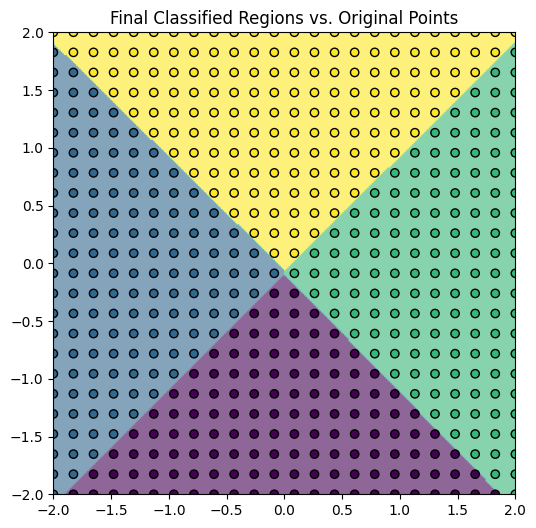

In [216]:
# Map colors
Colors = np.array([
    [1, 0, 0],  # Red
    [0, 1, 0],  # Green
    [0, 0, 1],  # Blue
    [1, 1, 0],  # Yellow
])

# Coordinates of the coloration points
N2 = 300
V = np.linspace(-2, 2, N2)
X, Y = np.meshgrid(V, V)
Coordinates2 = np.vstack((X.ravel(), Y.ravel())).T  # shape [N2*N2, 2]
Coordinates2 = torch.tensor(Coordinates2, dtype=torch.float32)

# Forward propagate to get output probabilities
with torch.no_grad():  # No need to compute gradients during prediction
    Probabilities2 = mlp(Coordinates2)
    _, Regions2 = torch.max(Probabilities2, dim=1)  # Get most probable regions

# Reshape Regions2 for plotting
Regions2 = Regions2.numpy().reshape(N2, N2)

plt.figure(figsize=(6, 6))
plt.imshow(Regions2, extent=(-2, 2, -2, 2), origin='lower', alpha=0.6)
plt.scatter(Coordinates[:, 0], Coordinates[:, 1], c=Regions, edgecolor='k')
plt.title('Final Classified Regions vs. Original Points')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

I needed to put way lower MSE or just let model run all epochs, otherwise the region wasnt accurate.

# 1.2 Classification of spirals with Levenberg-Marquardt algorithm


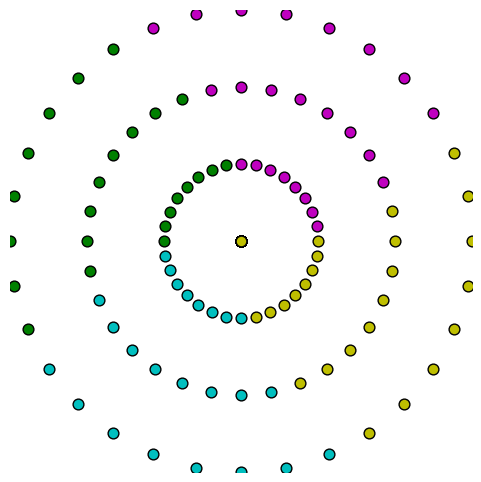

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
R = 4
k = 8
N = R
S = k * N

# Initialization
x0 = 0
y0 = 0
X = np.zeros((N, S))
Y = np.zeros((N, S))
Regions = np.zeros((N, S))

# Spirals coordinates and regions
for s in range(S):
    r = np.floor((s * R) / S).astype(int)
    for n in range(N):
        a0 = n / N * 2 * np.pi / k
        a = a0 + s * 2 * np.pi / S
        b = a0
        X[n, s] = b * np.cos(a) + x0
        Y[n, s] = b * np.sin(a) + y0
        Regions[n, s] = r + 1

# Reshape Coordinates and Regions
Coordinates = np.vstack((X.ravel(), Y.ravel()))
Regions = Regions.ravel()

# Figure
plt.figure(figsize=(6, 6))
plt.axis('off')
Colors = ['m', 'g', 'c', 'y']

# Plot points for each region
for r in range(1, R + 1):
    I = np.where(Regions == r)[0]
    plt.scatter(Coordinates[0, I], Coordinates[1, I], c=Colors[r - 1], edgecolor='k', s=60)

plt.xlim([np.min(X), np.max(X)])
plt.ylim([np.min(Y), np.max(Y)])
plt.gca().set_aspect('equal', adjustable='box')
plt.show()


In [ ]:
# Probabilities

Coordinates = torch.tensor(Coordinates.T, dtype=torch.float32)  #making tensor from coordinates array
Regions = torch.tensor(Regions, dtype=torch.long)

# Probabilities (one-hot encoding for 4 classes)
Probabilities = torch.zeros(R, len(Regions), dtype=torch.float32)  #create tensor filled with 0;s with size of 4 x len(reigons)
for n in range(len(Regions)):
    Probabilities[Regions[n]-1, n] = 1  

#MLP


#Training

#Map colors
